# Example: mesh a delineated watershed

Here we mesh the Coal Creek Watershed, CO as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

In [92]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import os,sys,yaml
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
# from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import fiona
import logging
import pandas 
import datetime
import cftime
pandas.options.display.max_columns = None


import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs
import watershed_workflow.land_cover_properties
import watershed_workflow.regions
import watershed_workflow.timeseries

watershed_workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)


In [94]:
watershed_workflow.config.set_data_directory('C:/Users/saddy/work/ats-workflow1/data')

In [95]:
import h5py
from modvis import ATSutils

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS (in UTM coordinates) that is included in the shapefile. 

<span style="color:blue;">If the CRS is in lat-lon (in degrees), convert it to UTM (in meters).</span>


In [96]:
# specify the input shapefile and a hint as to what HUC it is in.
watershed_name = 'RedButteCreek'
watershed_shapefile = f'../../data/examples/{watershed_name}/sources/shapefile/Red_butte_creek_upstream.shp'

#====== optional local files ======#
# These files are optional if you prefer WW to download these for you, which may take a long time...
# see the following Source section for manual download
watershed_landcover = f'../../data/examples/{watershed_name}/sources/land_cover/NLCD/NLCD_2016_Land_Cover_L48/NLCD_2016_Land_Cover_L48.tif'
watershed_glhymps = f'../../data/examples/{watershed_name}/sources/GLHYMPS/GLHYMPS.shp'
watershed_dtb = f'../../data/examples/{watershed_name}/sources/DTB/Global_absoluteDTB_M_250m_ll.tif'
watershed_modis_lulc = f'../../data/examples/{watershed_name}/sources/land_cover/MODIS/MCD12Q1.061_500m_aid0001.nc'
watershed_modis_lai = f'../../data/examples/{watershed_name}/sources/land_cover/MODIS/MCD15A3H.061_500m_aid0001.nc'

config = {} # this will store all the filenames used in input file
config_fname = f'../../data/examples/{watershed_name}/processed/config.yaml'

hint = '1602'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
huc = "16020204" # provide the huc code for that watershed. If `None`, the script will automatically search for the HUC code.
simplify = 50 # length scale to target average edge, same unit as the watershed CRS
prune_by_area_fraction = 0.05 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value

# start and end of simulation 
# try two year of transient simulation since the first year results will be discarded
start_date = "2010-10-1"
end_date = "2020-10-01"
# origin of simulation. By default, use the first available date of Daymet forcing. 
# This is necessary to ensure that all datesets use the same origin date.
origin_date = "1980-1-1"
nyears_cyclic_steadystate = 4 #total years of cyclic spinup 

# huc boundary refinement control
refine_d0 = 100 # distance from river in meter
refine_d1 = 500
refine_L0 = 200  # triangle cell length in meter
refine_L1 = 300
refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2


In [97]:
# logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile)

2025-04-24 17:18:33,333 - root - INFO: Meshing shape: ../../data/examples/RedButteCreek/sources/shapefile/Red_butte_creek_upstream.shp
2025-04-24 17:18:33,335 - root - INFO: ==============================
2025-04-24 17:18:33,336 - root - INFO: 
2025-04-24 17:18:33,337 - root - INFO: Loading shapes
2025-04-24 17:18:33,338 - root - INFO: ------------------------------
2025-04-24 17:18:33,338 - root - INFO: Loading file: '../../data/examples/RedButteCreek/sources/shapefile/Red_butte_creek_upstream.shp'
2025-04-24 17:18:33,421 - root - INFO: ... found 1 shapes
2025-04-24 17:18:33,422 - root - INFO: Converting to shapely
2025-04-24 17:18:33,456 - root - INFO:  ... done
2025-04-24 17:18:33,478 - root - INFO: Removing holes on 1 polygons
2025-04-24 17:18:33,479 - root - INFO:   -- removed interior
2025-04-24 17:18:33,481 - root - INFO:   -- union
2025-04-24 17:18:33,481 - root - INFO: Parsing 1 components for holes
2025-04-24 17:18:33,483 - root - INFO:   -- complete


In [98]:
# # Open the shapefile
# with fiona.open(watershed_shapefile) as shapefile:
#     # Iterate over the records
#     for record in shapefile:
#         # Get the geometry from the record
#         watershed_shp = shapely.geometry.shape(record['geometry'])

### Sources

A wide range of data sources are available and shown below:

| source | File_Manager | Options|
|:---:|:---:|:---:|
|sources['DEM']| `FileManagerNED()` | `1 arc-second` (*); `1/3 arc-second`|
|sources['HUC']| `FileManagerNHD()` | `NHDPlus` (*); `NHD`; `WBD`|
|sources['hydrography']| `FileManagerNHD()` | `NHDPlus` (*); `NHD`|
|sources['land cover']| `FileManagerNLCD()` | `NLCD (L48)` (*); `NLCD (AK)`; `MODIS`|
|sources['geologic structure']| `FileManagerGLHYMPS()` | `GLHYMPS` (*)|
|sources['soil structure']| `FileManagerNRCS()` | `NRCS SSURGO` (*)|
|sources['DTB']| `FileManagerSoilGrids2017()` | `SoilGrids2017` (*)|
|sources['lai']| `FileManagerMODISAppEEARS()` | `MODIS` (*)|
|sources['meteorology']| `FileManagerDaymet()` | `DayMet` (*)|

Note, custom sources can be imported using:

```python
# if raster
sources['SOURCE NAME'] = watershed_workflow.source_list.FileManagerRaster('PATH/TO/RASTER')

# for example
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster('./Global_absoluteDTB_M_250m_ll.tif')
```

By default, Watershed-Workflow (WW) will place all the downloads in a folder named `data_library` or the mounted data volume and has the following structure (generated by WW):

```bash
.
├── dem
│   ├── 13as_raw
│   └── 1as_raw
├── hydrography
├── land_cover
│   ├── MODIS
│   ├── NLCD_2016_Land_Cover_L48
│   └── NLCD_2019_Land_Cover_L48
├── meteorology
│   └── daymet
└── soil_structure
    ├── GLHYMPS
    ├── SSURGO
    ├── SoilGrids2017
    └── depth-to-bedrock
```

Some of the sources do not have API and may need to be downloaded manually. Here are a list of sources to download:

| source | Download Link| Local Path| Notes|
|:---:|:---:|:---:|:---:|
| GLHYMPS v2  | [Download link](https://doi.org/10.5683/SP2/TTJNIU) | `data/soil_structure/GLHYMPS`| ~2.4 GB. Unzip the .zip file and place all the files under the path|
| Depth-to-bedrock (~2.4 GB) | [Download link](http://globalchange.bnu.edu.cn/research/dtb.jsp) | `data/soil_structure/depth-to-bedrock`| ~10 GB. Look for file named `Global_absoluteDTB_M_250m_ll.tif` (250 m resolution). This file is slightly different from the data found in [SoilGrids](https://soilgrids.org/). Why?|
|NLCD landcover| [Download link](https://www.sciencebase.gov/catalog/item/604a4fb1d34eb120311b0039)| `data/land_cover/NLCD_YEAR_Land_Cover_L48`|~2.2 GB. The Year 2016 product is used in this example, but feel free to use the most recent product|
|MODIS|See [LAI](#lai) section on how to download MODIS product manually| `data/land_cover/MODIS`| You will need an [AppEEARS](https://appeears.earthdatacloud.nasa.gov/) account to download files|

In [99]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
# sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017()

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
sources['land cover'] = watershed_workflow.source_list.FileManagerRaster(watershed_landcover)
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS(watershed_glhymps)
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster(watershed_dtb)
# sources['MODIS LULC'] = watershed_workflow.source_list.FileManagerRaster(watershed_modis_lulc)

watershed_workflow.source_list.log_sources(sources)

2025-04-24 17:18:33,535 - root - INFO: Using sources:
2025-04-24 17:18:33,537 - root - INFO: --------------
2025-04-24 17:18:33,538 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2025-04-24 17:18:33,538 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2025-04-24 17:18:33,539 - root - INFO: DEM: National Elevation Dataset (NED)
2025-04-24 17:18:33,539 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-04-24 17:18:33,540 - root - INFO: geologic structure: ../../data/examples/RedButteCreek/sources/GLHYMPS/GLHYMPS.shp
2025-04-24 17:18:33,542 - root - INFO: land cover: raster
2025-04-24 17:18:33,542 - root - INFO: lai: MODIS
2025-04-24 17:18:33,543 - root - INFO: depth to bedrock: raster
2025-04-24 17:18:33,543 - root - INFO: meteorology: DayMet 1km


In [100]:
# immediately put in request for land cover data -- downloading from Appeears
# can take some time as they must synthesize the data 

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

<span style="color:blue;">Key parameters: </span>

- `prune_by_area` -- prune based on drainage area. This will affect the density of the river network.
- `simplify` -- length scale to target average edge, same unit as the watershed CRS. This will affect the smoothness of watershed boundary and river network

In [101]:
# find what HUC our shape is in
if huc is None:
    huc = watershed_workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint, shrink_factor=0.1)
logging.info("Found watershed in HUC: {}".format(huc))

2025-04-24 17:18:33,583 - root - INFO: Found watershed in HUC: 16020204


In [102]:
rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], hint, 
                                      watershed.exterior(), crs, crs, 
                                        in_network=True, properties=True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq', 
                                                 ignore_small_rivers=ignore_small_rivers,
                                                prune_by_area=prune_by_area_fraction * watershed.exterior().area * 1.e-6,
                                                remove_diversions=True,
                                             remove_braided_divergences=True)
    rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                               snap_tol = 0.75*simplify, cut_intersections=True)

else:
    rivers = list()
    watershed_workflow.split_hucs.simplify(watershed, simplify)



2025-04-24 17:18:33,614 - root - INFO: 
2025-04-24 17:18:33,615 - root - INFO: Loading Hydrography
2025-04-24 17:18:33,616 - root - INFO: ------------------------------
2025-04-24 17:18:33,616 - root - INFO: Loading streams in HUC 1602
2025-04-24 17:18:33,617 - root - INFO:          and/or bounds (431389.99999981525, 4513580.00000015, 437449.99999981525, 4519530.000000152)
2025-04-24 17:18:33,650 - root - INFO:   Using Hydrography file "C:/Users/saddy/work/ats-workflow1/data/hydrography/NHDPlus_H_1602_GDB/NHDPlus_H_1602.gdb"
2025-04-24 17:18:33,651 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening 'C:/Users/saddy/work/ats-workflow1/data/hydrography/NHDPlus_H_1602_GDB/NHDPlus_H_1602.gdb' layer 'NHDFlowline' for streams in '(431389.99999981525, 4513580.00000015, 437449.99999981525, 4519530.000000152)'
2025-04-24 17:18:37,427 - root - INFO:   Found total of 95 in bounds.
2025-04-24 17:18:37,430 - root - INFO: Filtering reaches not in-network
2025-04-

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


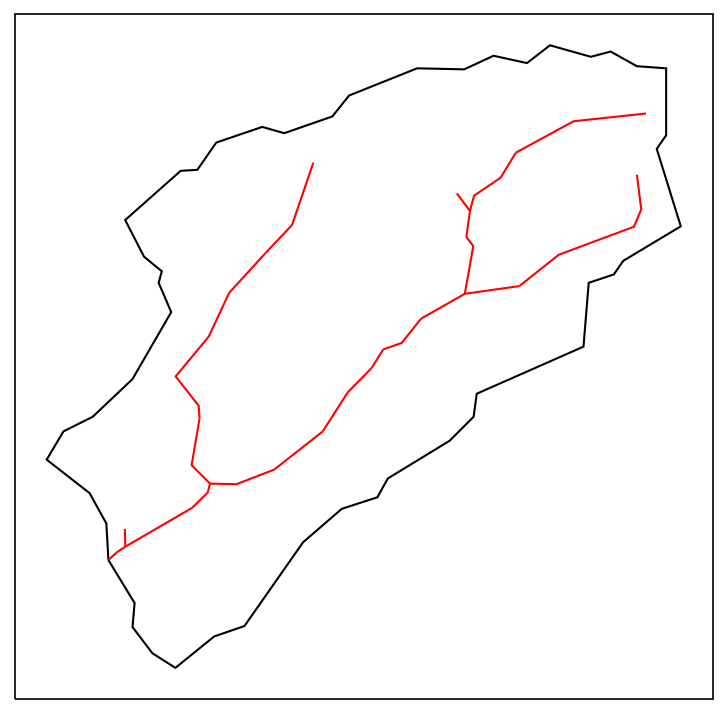

In [103]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

### Meshing

Triangulation refinement: refine triangles if their area (in m^2) is greater than A(d), where d is the distance from the triangle centroid to the nearest stream. A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

Adjust distance and area parameters to refine triangles. 

<span style="color:blue;"> Be careful with the min triangular area (e.g., \<1 m^2) in the meshes. It will likely cause the model to run extremely slowly. You may also receive an error saying the tolerance value (i.e., the minimum node distance) is too small.</span> You can increase the smoothing parameter such as `simplify_hucs` or `simplify_rivers` in the above step to make the boundaries smoother and meshes coarser.


2025-04-24 17:18:44,288 - root - INFO: 
2025-04-24 17:18:44,290 - root - INFO: Triangulation
2025-04-24 17:18:44,291 - root - INFO: ------------------------------
2025-04-24 17:18:44,293 - root - INFO: Triangulating...
2025-04-24 17:18:44,295 - root - INFO:    48 points and 48 facets
2025-04-24 17:18:44,296 - root - INFO:  checking graph consistency
2025-04-24 17:18:44,297 - root - INFO:  tolerance is set to 1
2025-04-24 17:18:44,299 - root - INFO:  building graph data structures
2025-04-24 17:18:44,302 - root - INFO:  triangle.build...
2025-04-24 17:18:44,507 - root - INFO:   ...built: 553 mesh points and 1022 triangles
2025-04-24 17:18:44,508 - root - INFO: Plotting triangulation diagnostics
2025-04-24 17:18:44,566 - root - INFO:   min area = 7105.149658203125
2025-04-24 17:18:44,567 - root - INFO:   max area = 44510.73742675781


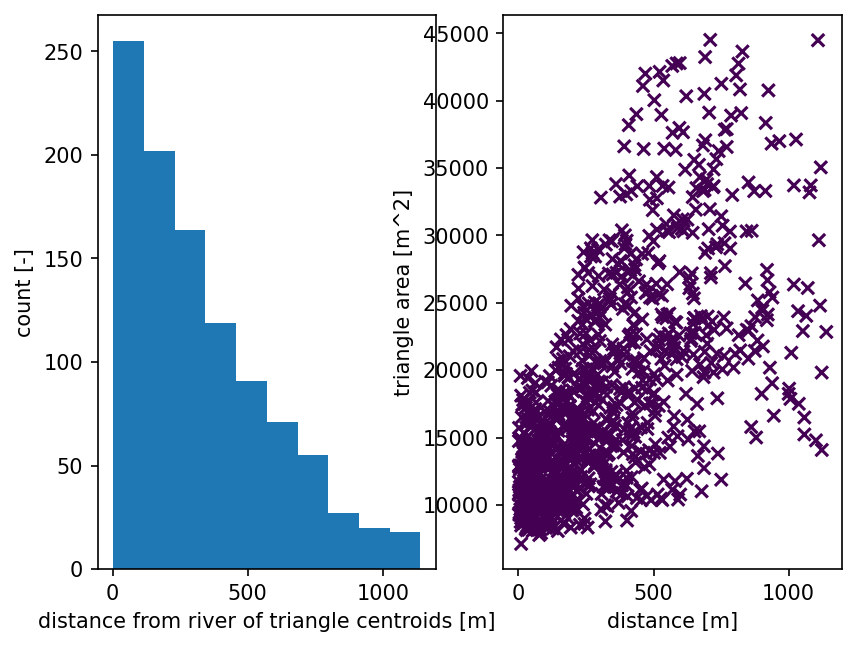

In [104]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = refine_d0; d1 = refine_d1 # distance in meters
A0 = refine_A0; A1 = refine_A1 # triangular area in m^2
# A0 = 5000; A1 = 50000 # triangular area in m^2
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, dists = watershed_workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)


In [105]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

2025-04-24 17:18:44,802 - root - INFO: 
2025-04-24 17:18:44,803 - root - INFO: Loading Raster
2025-04-24 17:18:44,804 - root - INFO: ------------------------------
2025-04-24 17:18:44,805 - root - INFO: Collecting raster
2025-04-24 17:18:44,809 - root - INFO: Collecting DEMs to tile bounds: [-111.82319870916159, 40.76043263091969, -111.7316022121321, 40.8343145359636]
2025-04-24 17:18:44,820 - root - INFO:   Need:
2025-04-24 17:18:44,821 - root - INFO:     C:/Users/saddy/work/ats-workflow1/data/dem/USGS_NED_1as_n41_w112.tif
2025-04-24 17:18:44,824 - root - INFO: source files already exist!
2025-04-24 17:18:44,861 - root - INFO: ... got raster of shape: (266, 330)
2025-04-24 17:18:44,863 - root - INFO: ... got raster bounds: (-111.82319870916159, 40.8343145359636, -111.73153204249188, 40.76042564707225)


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

[Text(4513000.0, 0, ''),
 Text(4514000.0, 0, ''),
 Text(4515000.0, 0, ''),
 Text(4516000.0, 0, ''),
 Text(4517000.0, 0, ''),
 Text(4518000.0, 0, ''),
 Text(4519000.0, 0, ''),
 Text(4520000.0, 0, '')]

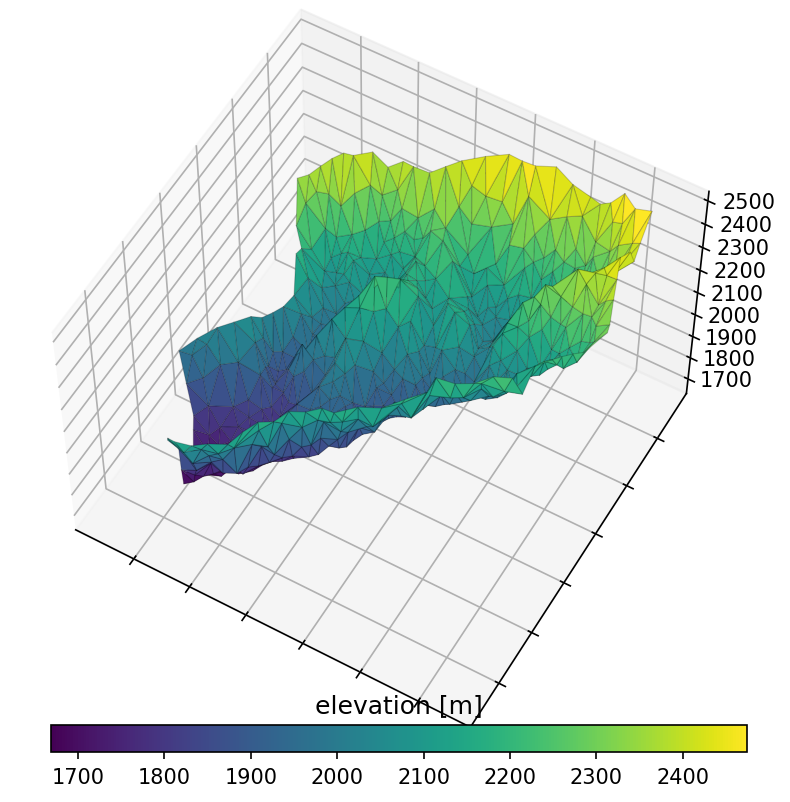

In [106]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = watershed_workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55, 300)
#ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())




(431147.4999998243, 437692.499999991)
(4513282.499999993, 4519827.500000159)


Text(0.5, 1.0, 'Elevation [m]')

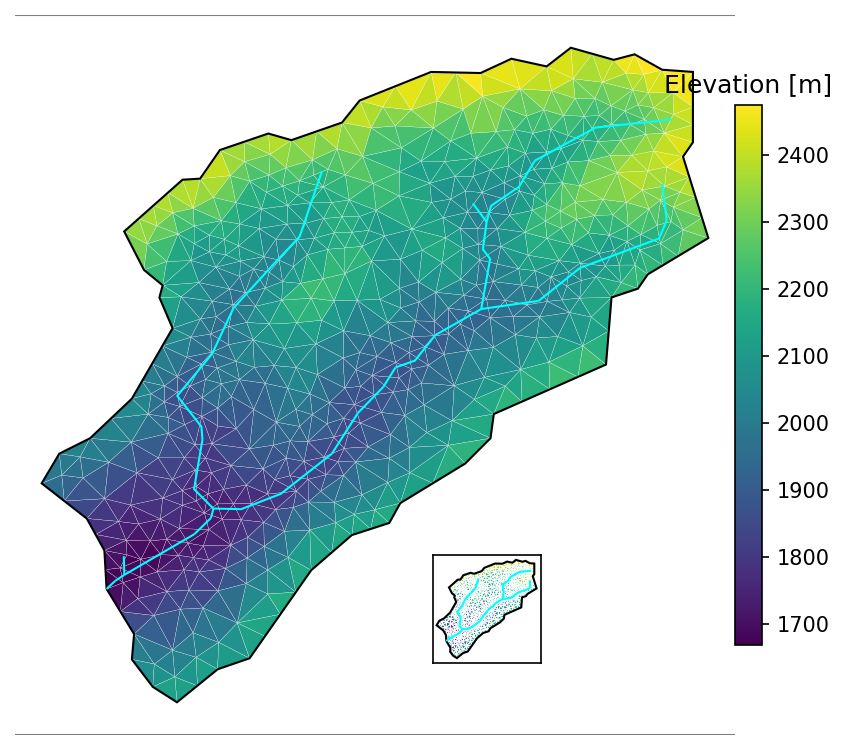

In [107]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.8,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.58,0.10,0.15,0.15])
cbax = fig.add_axes([.85,0.2,0.03,0.6])

#xlim = (320500., 321000.)
#ylim = (4302000., 4302500.)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')

mp2 = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.5)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1)
#ax2.set_xlim(xlim)
#ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal', 'datalim')
ax.indicate_inset_zoom(ax2, edgecolor='k')

# add scalebar, use 1 for UTM coordinates, the default unit is "m"
#scalebar1 = ScaleBar(1, location = "lower left", pad=3, frameon=False)
# ax.add_artist(scalebar1)
ax.axis('off')
print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')
# fig.savefig('../figures/watershed_mesh-2d.jpg',dpi=300)

In [108]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

Condition the mesh to remove pits and ponds in the meshes. <span style="color:blue;">Advanced tip: use `fill_pits_dual(m2, is_waterbody=waterbody_mask) ` if there exists lakes or reservoirs where pits should not be removed! </span>

max diff =  41.82886025941434


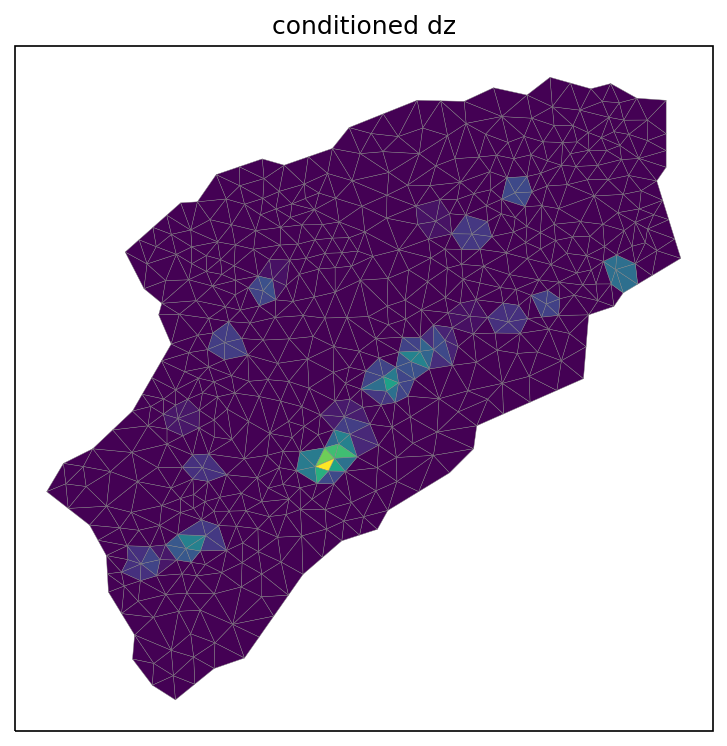

In [109]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fill_pits(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

### Add watershed outlet (optional)

This will add the outlet region in the mesh for better capturing the streamflow in post-processing. Here there is only one catchment with one outlet. However, this may be necessary for watershed with multiple subcatchments with multiple outlets.

In [110]:
list(watershed.polygons())[0].properties

OrderedDict([('Name', 'UT20250411185522067000')])

Identify outlets for each catchment. Plot the outlets to verify the correct outlet locations.

Available functions to find the outlets include:
- `find_outlets_by_crossings()`: find all outlets using river network's crossing points on HUC boundary. This may not work well if river has multiple crossings on the same boundary.
- `find_outlets_by_elevation()`: find all outlets by the minimum elevation. This does not work if the minimum elevation within the watershed is not located at the outlet.
- `find_outlets_by_hydroseq()`: find outlets using the HydroSequence VAA of NHDPlus. This may take a while.

In [111]:
watershed_workflow.split_hucs.find_outlets_by_elevation(watershed, crs, dem, dem_profile)

In [112]:
# add labeled sets for subcatcprojectnts and outlets. 
# Here we use HUC12 code, but any other labels would work.
outlet_width = 500  # half-width (unit is the same as in watershed CRS) to track a labeled set on which to get discharge. Use large values to be conservative.
watershed_polygons = list(watershed.polygons())
#catchment_labels = [str(p.properties['HUC1602']) for p in watershed_polygons]
catchment_labels = ["RedButteCreek"]
watershed_workflow.regions.add_watershed_regions_and_outlets(m2, watershed, 
                                                outlet_width=outlet_width, 
                                               labels=catchment_labels)

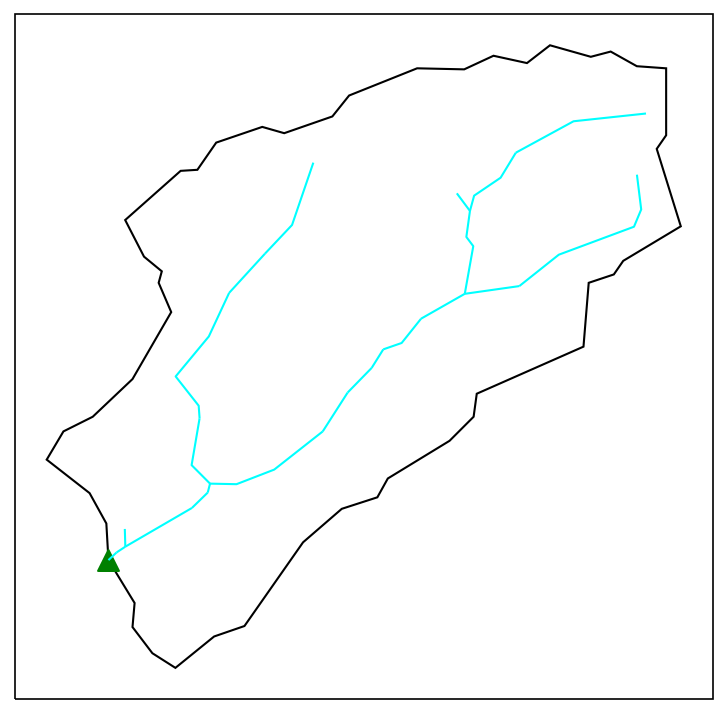

In [113]:
# plot outlets
# fig,ax=plt.subplots(1,1,figsize=(6,4))
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.hucs(watershed, crs, color='k', outlet_marker = '^', ax =ax, linewidth=1)
watershed_workflow.plot.rivers(rivers, crs,  color='aqua', ax =ax, linewidth=1)

In [114]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "RedButteCreek"
10001 : CELL : "RedButteCreek surface"
10002 : FACE : "RedButteCreek boundary"
10003 : FACE : "RedButteCreek outlet"
10004 : FACE : "surface domain outlet"


In [115]:
config['catchment_labels'] = catchment_labels

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

### Land Cover

In [116]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = watershed_workflow.values_from_raster(m2.centroids, crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2025-04-24 17:18:46,095 - root - INFO: 
2025-04-24 17:18:46,096 - root - INFO: Loading Raster
2025-04-24 17:18:46,097 - root - INFO: ------------------------------
2025-04-24 17:18:46,098 - root - INFO: Collecting raster
2025-04-24 17:18:46,112 - root - INFO: bounds in my_crs: (-111.81319870916158, 40.770432630919686, -111.74160221213211, 40.8243145359636)
2025-04-24 17:18:46,119 - root - INFO: ... got raster of shape: (124, 141)
2025-04-24 17:18:46,121 - root - INFO: ... got raster bounds: (-111.81367609790183, 40.82448410001818, -111.74130720461426, 40.77004087693249)
2025-04-24 17:18:46,126 - root - INFO: Found land cover dtypes: uint8
2025-04-24 17:18:46,126 - root - INFO: Found land cover types: {41, 42, 43, 81, 52, 21, 90, 95}


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x7fbb69ecfb80>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7fbb69ecf2e0>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [41 41 41 ... 52 41 41]


(431087.0, 437753.0, 4513282.5, 4519827.5)

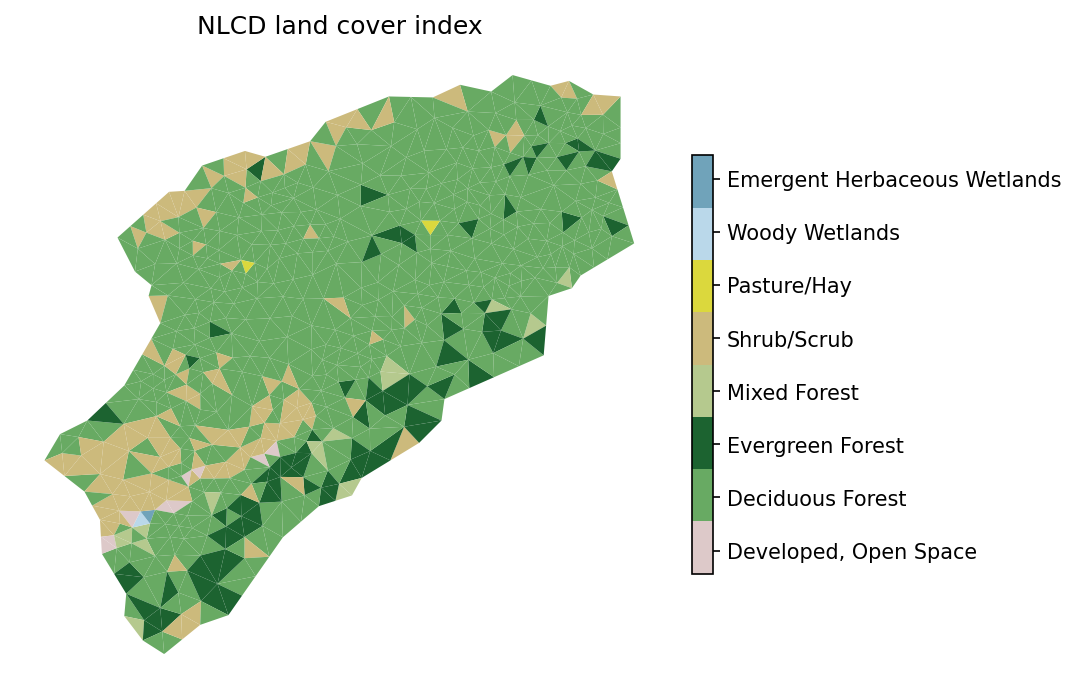

In [117]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, 
                                     norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices), cmap=nlcd_cmap, 
                                         labels=nlcd_labels) 
ax.set_title("NLCD land cover index")
ax.axis('off')

In [118]:
nlcd_indices, nlcd_labels

([21, 41, 42, 43, 52, 81, 90, 95],
 ['Developed, Open Space',
  'Deciduous Forest',
  'Evergreen Forest',
  'Mixed Forest',
  'Shrub/Scrub',
  'Pasture/Hay',
  'Woody Wetlands',
  'Emergent Herbaceous Wetlands'])

In [119]:
# # add labeled sets to the mesh for NLCD
# nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
# watershed_workflow.mesh.add_nlcd_labeled_sets(m2, lc, nlcd_labels_dict)

# for ls in m2.labeled_sets:
#     print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

### LAI
<a id='lai'></a>
Download MODIS LAI and LULC, block until it is finished!
NOTE: if you get an error here about MODIS AppEEARs username and password, realize that you must register for a login in the AppEEARs database.  See: `print(sources['lai'].__doc__)`

You may encounter download issues if the files are too big. In that case, manually download the MODIS data using [AppEEARS](https://appeears.earthdatacloud.nasa.gov/). Here are brief steps:

1. Sign in if you already registered. 
2. Click `Extract --> Area`
3. Click `Start a new request`
4. Upload the watershed shapefile (in lat-lon). <span style="color:blue;"> Important: draw a box region surrounding the watershed to avoid downloading no_data! </span>
5. Choose `Start Date` (e.g., 2002-7-1) and `End Date` (e.g., 2021-1-1)
6. Select product for Landcover (e.g., `MCD12Q1.006`) or LAI (e.g., `MCD15A3H.006`)
7. Select layers or for landcover (i.e., `LC_Type1`) or LAI (i.e., `Lai_500m`). You may choose to include all layers, but not all will be used.
8. Select `NetCDF-4` as the output file format 
9. Click `Submit`. It will send an email after download is completed.

In [120]:
## Uncomment the next three lines if you want to try downloading through WW
# modis = sources['lai'].get_data(watershed.exterior(), crs, start, end)
# if not isinstance(modis, watershed_workflow.datasets.State):
#     modis = sources['lai'].wait(modis)
modis = sources['lai'].get_data(watershed.exterior(), crs, variables = ['LULC', 'LAI'], filenames=[watershed_modis_lulc, watershed_modis_lai])

2025-04-24 17:18:46,568 - root - INFO: ... reading LULC from ../../data/examples/RedButteCreek/sources/land_cover/MODIS/MCD12Q1.061_500m_aid0001.nc
2025-04-24 17:18:46,617 - root - INFO: ... reading LAI from ../../data/examples/RedButteCreek/sources/land_cover/MODIS/MCD15A3H.061_500m_aid0001.nc


3653
3652


In [121]:
# drop data on leap day -- MODIS is real data, but we work with data on a noleap calendar.  This drops Dec 31
for dset in modis.collections:
    watershed_workflow.datasets.removeLeapDay(dset)

<class 'watershed_workflow.datasets.Dataset'> <class 'str'> LULC
<class 'watershed_workflow.datasets.Dataset'> <class 'str'> LAI


In [122]:
# convert Gregorian time to datetime64
modis_times = np.array([np.datetime64(t.strftime('%Y-%m-%d')) for t in modis['LULC'].times])

modis_times

array(['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
       '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
       '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01',
       '2022-01-01', '2023-01-01'], dtype='datetime64[D]')

In [123]:
# select the year of 2016 for MODIS landcover to match 2016 NLCD land cover
lc_idx = np.where(modis_times == datetime.date(2016, 1, 1))[0][0]
lc_idx

6

In [124]:
# resample the raster to the triangles
modis_lc = watershed_workflow.values_from_raster(m2.centroids, crs, modis['LULC'].data[lc_idx,:,:], 
                                                 modis['LULC'].profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(modis_lc.dtype))
logging.info('Found land cover types: {}'.format(set(modis_lc)))

2025-04-24 17:18:46,807 - root - INFO: Found land cover dtypes: int16
2025-04-24 17:18:46,808 - root - INFO: Found land cover types: {8, 9, 10, 1}


In [125]:
assert (np.unique(modis_lc)>0).all(), f"Found negative index: {np.unique(modis_lc)[np.unique(modis_lc)<0]} in landcover types! Double check your MODIS LULC download and make sure it covers a larger area than the watershed (e.g., a box that bounds the watershed)"

kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x7fbb69d43100>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7fbb69d41f60>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [ 9  9  9 ... 10  9  9]


(431087.0, 437753.0, 4513282.5, 4519827.5)

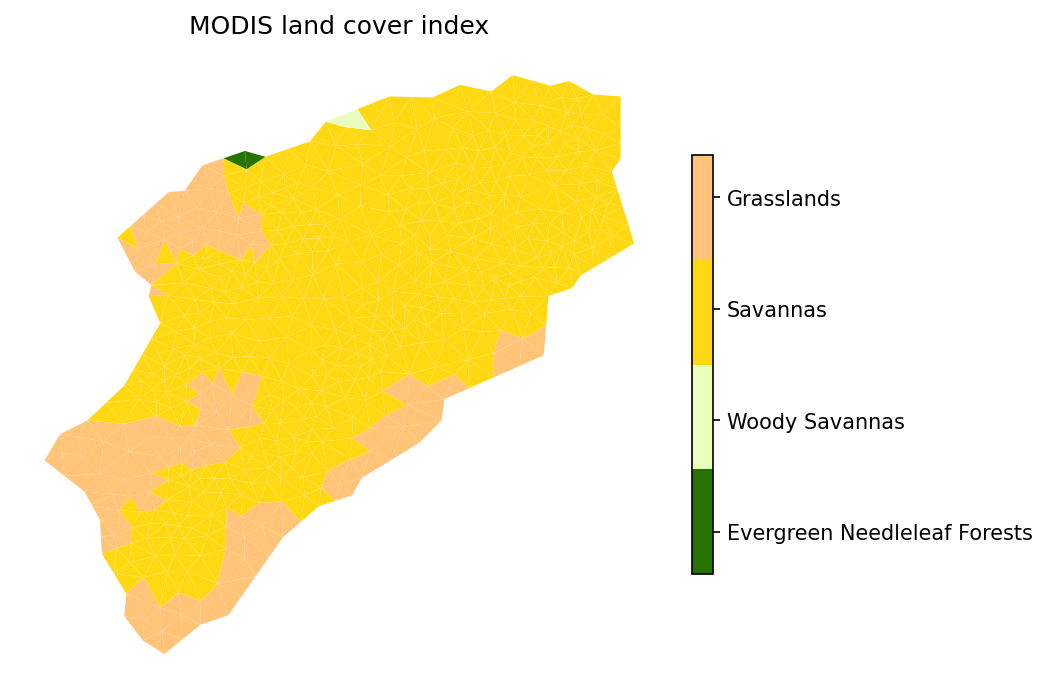

In [126]:
# plot the modis lulc data

# -- get the MODIS colormap which uses official MODIS colors and labels
modis_indices, modis_cmap, modis_norm, modis_ticks, modis_labels = \
                watershed_workflow.colors.generate_modis_colormap(modis_lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=modis_lc, cmap=modis_cmap, 
                                     norm=modis_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(modis_indices), cmap=modis_cmap, 
                                         labels=modis_labels) 
ax.set_title("MODIS land cover index")
ax.axis('off')

In [127]:
# plot both NLCD and MODIS to form the image cross-correlation
# if generate_plots:
# axs = []
# #fig, a0 = watershed_workflow.plot.get_ax(lc_profile['crs'], nrow=1, ncol=2, index=1, figsize=(15,5))
# axs.append(a0) 

# plot the image
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
            watershed_workflow.colors.generate_nlcd_colormap(np.unique(lc_raster))

#im = watershed_workflow.plot.raster(lc_profile, lc_raster, ax=axs[0], cmap=nlcd_cmap, norm=nlcd_norm)
# watershed_workflow.plot.shply(watershed_workflow.warp.shply(watershed.exterior(), crs, lc_profile['crs']), lc_profile['crs'], 'k', axs[0])
# watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(lc_raster)), cmap=nlcd_cmap, labels=nlcd_labels, ax=axs[0]) 
# axs[0].set_title("NLCD Index")


modis_raster = modis['LULC'].data[-1]
modis_profile = modis['LULC'].profile

# a1 = watershed_workflow.plot.get_ax(modis_profile['crs'], nrow=1, ncol=2, index=2, fig=fig)
# axs.append(a1)

modis_indices, modis_cmap, modis_norm, modis_ticks, modis_labels = \
            watershed_workflow.colors.generate_modis_colormap(np.unique(modis_raster))
# print(modis_indices, modis_labels)
# print(modis_cmap(8))
# print(modis_cmap(4))
# im = watershed_workflow.plot.raster(modis_profile, modis_raster, ax=axs[1], cmap=modis_cmap, norm=modis_norm)
# watershed_workflow.plot.shply(watershed_workflow.warp.shply(watershed.exterior(), crs, modis_profile['crs']), modis_profile['crs'], 'k', axs[1])
# watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(modis_raster)), cmap=modis_cmap, labels=modis_labels, ax=axs[1]) 
# axs[1].set_title("MODIS LULC Index")


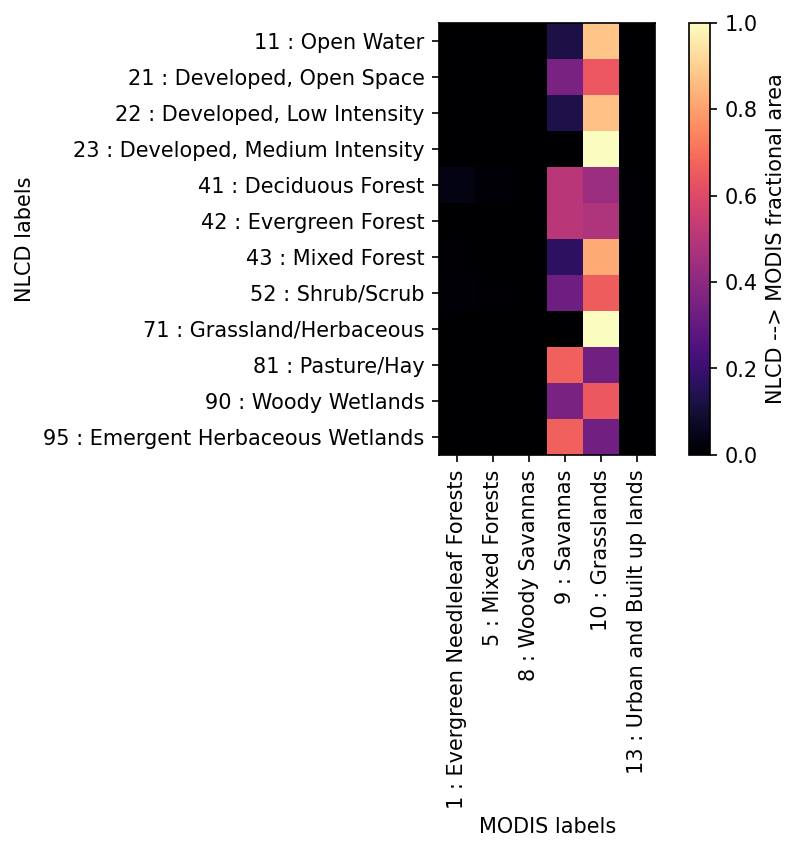

In [128]:
# determine a crosswalk between NLCD and MODIS -- for each NLCD index, 
# what MODIS index correlates best. 
crosswalk = watershed_workflow.land_cover_properties.computeMaximalCrosswalkCorrelation(
    modis['LULC'].profile, modis['LULC'].data[lc_idx,:,:], lc_profile, lc_raster)

In [129]:
# print the crosswalk.
crosswalk

{11: 10,
 21: 10,
 22: 10,
 23: 10,
 41: 9,
 42: 9,
 43: 10,
 52: 10,
 71: 10,
 81: 9,
 90: 10,
 95: 9}

In [130]:
nlcd_color_new = 99 * np.ones_like(lc)

for k,v in crosswalk.items():
    # for label in v:
    # index = sources['land cover'].indices[label]
    nlcd_color_new[np.where(lc == k)] = v

In [131]:
np.unique(nlcd_color_new)

array([ 9, 10], dtype=uint8)

kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x7fbb69ddac80>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7fbb69dda560>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [ 9  9  9 ... 10  9  9]


/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


(431087.0, 437753.0, 4513282.5, 4519827.5)

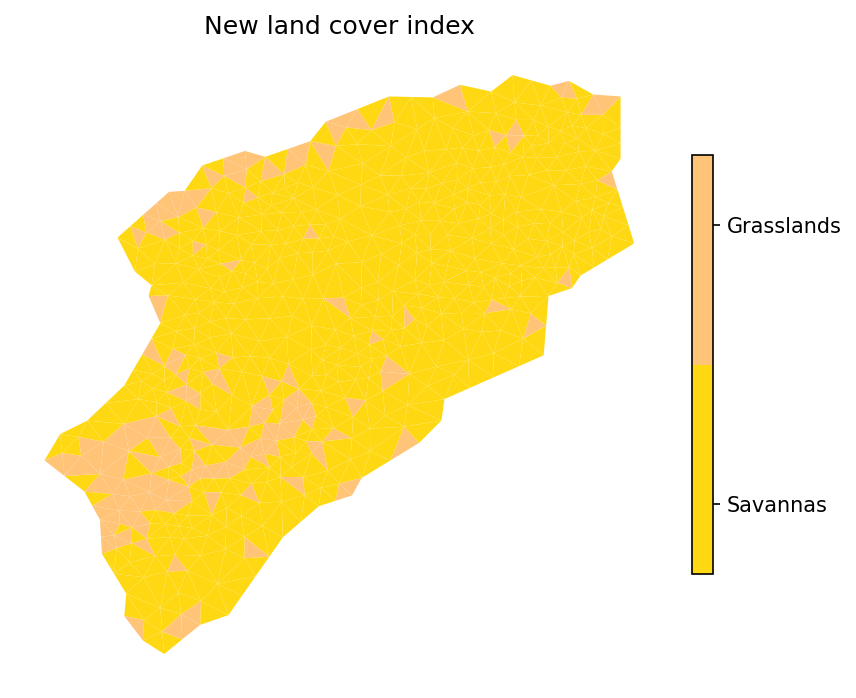

In [132]:
# plot new NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices_new, nlcd_cmap_new, nlcd_norm_new, nlcd_ticks_new, nlcd_labels_new = \
                watershed_workflow.colors.generate_modis_colormap(nlcd_color_new)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=nlcd_color_new, cmap=nlcd_cmap_new, 
                                     norm=nlcd_norm_new, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices_new), cmap=nlcd_cmap_new, 
                                         labels=nlcd_labels_new) 
ax.set_title("New land cover index")
ax.axis('off')

In [133]:
nlcd_indices_new, nlcd_labels_new

([9, 10], ['Savannas', 'Grasslands'])

In [134]:
# add labeled sets to the mesh for new NLCD
# nlcd_labels_new = ['MODIS ' + i for i in nlcd_labels_new] # comment this to be consistent with the column labels in pandas
nlcd_labels_dict = dict(zip(nlcd_indices_new, nlcd_labels_new))

# Assert that the list does NOT contain 1, 2, or 3
assert all(x not in nlcd_indices_new for x in [1, 2, 3]), "MODIS indices contain 1, 2, or 3, which are reserved labels for surface, bottom and sidesets!"
watershed_workflow.regions.add_nlcd_labeled_sets(m2, nlcd_color_new, nlcd_labels_dict)

In [135]:
config['nlcd_indices'] = [int(i) for i in nlcd_indices_new]
config['nlcd_labels'] = nlcd_labels_new

In [136]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "RedButteCreek"
10001 : CELL : "RedButteCreek surface"
10002 : FACE : "RedButteCreek boundary"
10003 : FACE : "RedButteCreek outlet"
10004 : FACE : "surface domain outlet"
9 : CELL : "Savannas"
10 : CELL : "Grasslands"


In [137]:
# compute area averaged LAI for each modis land cover
lai_time_series = watershed_workflow.land_cover_properties.computeTimeSeries(
modis['LAI'], modis['LULC'], polygon=watershed.exterior(), polygon_crs=crs)

# # convert Gregorian time to datetime64
# lai_time_series['time [datetime]'] = np.array([np.datetime64(t.strftime('%Y-%m-%d')) for t in lai_time_series['time [datetime]']])

lai_time_series

time [datetime]  Savannas LAI [-]  Grasslands LAI [-]
0     2009-12-31 00:00:00          0.081176            0.037209
1     2010-01-01 00:00:00          0.077647            0.030233
2     2010-01-05 00:00:00          0.088235            0.044186
3     2010-01-09 00:00:00          0.089412            0.058140
4     2010-01-13 00:00:00          0.098824            0.083721
...                   ...               ...                 ...
1368  2024-12-14 00:00:00          0.232941            0.248837
1369  2024-12-18 00:00:00          0.243529            0.272093
1370  2024-12-22 00:00:00          0.478824            0.355814
1371  2024-12-26 00:00:00          0.000000            0.000000
1372  2024-12-30 00:00:00          0.025882            0.053488

[1373 rows x 3 columns]

In [138]:
# # compute area averaged LAI for each modis land cover
# lai_time_series = watershed_workflow.land_cover_properties.computeTimeSeries(
# modis['LAI'], modis['LULC'], unique_lc = unique_modis, lc_idx = lc_idx)
# lai_time_series

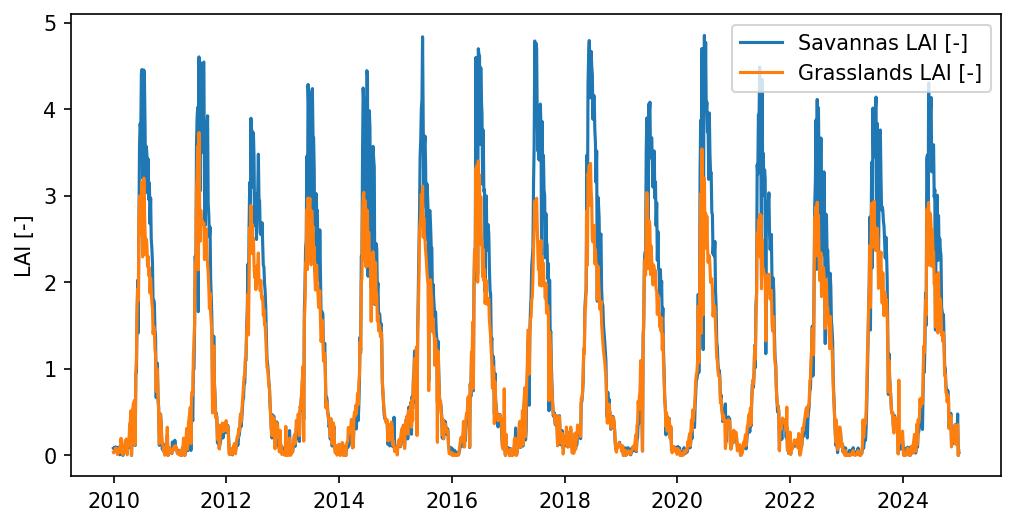

In [139]:
# plot LAI
fig,ax = plt.subplots(1,1, figsize=(8,4))
times = np.array([datetime.datetime(t.year, t.month, t.day) for t in lai_time_series['time [datetime]']])

# times = pandas.to_datetime(lai_time_series['time [datetime]'])
for icol in lai_time_series.columns[1:]:
    ax.plot(times, lai_time_series[icol], label = icol)
plt.ylabel("LAI [-]")
ax.legend()

In [140]:
time0_dt = datetime.datetime.strptime(origin_date, "%Y-%m-%d")
time0_cftime = cftime.DatetimeNoLeap(time0_dt.year, time0_dt.month, time0_dt.day)

# write raw LAI to disk
config['LAI_filename'] = os.path.join('..', '..', 'data', 'examples', watershed_name, 'processed', 'watershed_lai_raw.h5')
watershed_workflow.io.write_timeseries_to_hdf5(config['LAI_filename'], lai_time_series, 
                                              attributes={'name': 'MODIS LAI based on MODIS LULC',
                                                         'unit': 'none'}, 
                                               time0=time0_cftime)                                            

2025-04-24 17:18:48,709 - root - INFO: Writing HDF5 file: ../../data/examples/RedButteCreek/processed/watershed_lai_raw.h5


Generate smoothed MODIS LAI data for spinup runs.

In [141]:
# also compute a typical year of LAI
# the start year 2000 can be arbitary since all time are relative in cyclic runs
lai_time_series_smoothed = watershed_workflow.timeseries.computeAverageYear(lai_time_series, output_nyears=nyears_cyclic_steadystate, 
                                                                            start_year=2000, smooth=True)
lai_time_series_smoothed

time [datetime]  Savannas LAI [-]  Grasslands LAI [-]
0     2000-01-01 00:00:00          0.106320            0.098396
1     2000-01-02 00:00:00          0.104874            0.095373
2     2000-01-03 00:00:00          0.103272            0.092545
3     2000-01-04 00:00:00          0.101845            0.090453
4     2000-01-05 00:00:00          0.100606            0.089257
...                   ...               ...                 ...
1455  2003-12-27 00:00:00          0.111220            0.111507
1456  2003-12-28 00:00:00          0.109961            0.108868
1457  2003-12-29 00:00:00          0.109048            0.106337
1458  2003-12-30 00:00:00          0.108380            0.103839
1459  2003-12-31 00:00:00          0.107479            0.101205

[1460 rows x 3 columns]

In [142]:
# # compute area averaged LAI for each modis land cover
# # unique_nlcd = list(np.unique(lc))
# unique_modis = modis_indices

# lai_time_series_smoothed = watershed_workflow.land_cover_properties.computeTimeSeries(
# modis['LAI'], modis['LULC'], polygon=watershed_shp, polygon_crs=crs, 
#     unique_lc = unique_modis, lc_idx = lc_idx)



# # convert Gregorian time to datetime64
# lai_time_series_smoothed['time [datetime]'] = np.array([np.datetime64(t.strftime('%Y-%m-%d')) for t in lai_time_series_smoothed['time [datetime]']])


# lai_time_series_smoothed

In [143]:
# # compute area averaged LAI for each modis land cover
# lai_time_series_smoothed = watershed_workflow.land_cover_properties.compute_time_series(
# modis['LAI'], modis['LULC'], unique_lc = unique_modis, lc_idx = lc_idx, smooth=True)
# lai_time_series_smoothed

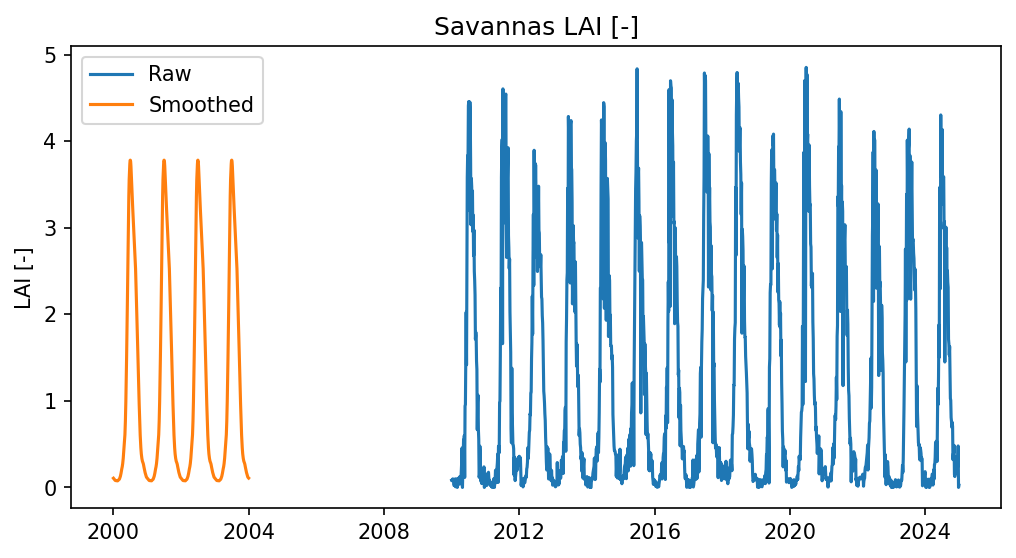

In [144]:
# plot LAI
ilc = lai_time_series.columns[1]
fig,ax = plt.subplots(1,1, figsize=(8,4))
# times = pandas.to_datetime(lai_time_series['time [datetime]'])
new_times = np.array([datetime.datetime(t.year, t.month, t.day) for t in lai_time_series_smoothed['time [datetime]']])

# new_times = pandas.to_datetime(lai_time_series_smoothed['time [datetime]'])

ax.plot(times, lai_time_series[ilc], label = "Raw")
ax.plot(new_times, lai_time_series_smoothed[ilc], label = "Smoothed")
plt.ylabel("LAI [-]")
plt.title(ilc)
ax.legend()

In [145]:
# write to disk
config['LAI_typical_filename'] = os.path.join('..', '..', 'data', 'examples', watershed_name, 'processed', 'watershed_lai_typical.h5')
attributes={'name':f'Typical LAI generated MODIS LAI data from {times[0]} to {times[len(times)-1]}, averaged for all days across each year, then repeated for 10 years',
           'origin date':origin_date}

watershed_workflow.io.write_timeseries_to_hdf5(config['LAI_typical_filename'], 
                                               lai_time_series_smoothed, 
                                               time0=None) # use the first date as the time0, relative time to be consistent with start time in xml file

2025-04-24 17:18:49,047 - root - INFO: Writing HDF5 file: ../../data/examples/RedButteCreek/processed/watershed_lai_typical.h5


## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [146]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], [watershed.exterior(),],
                                      crs, crs, properties=True)


# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array(soil_survey_props['mukey'][:], np.int32)
    
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    watershed.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)



soil_color = soil_color.astype(int)

2025-04-24 17:18:49,079 - root - INFO: 
2025-04-24 17:18:49,080 - root - INFO: Loading shapes
2025-04-24 17:18:49,081 - root - INFO: ------------------------------
2025-04-24 17:18:49,097 - root - INFO: Attempting to download source for target 'C:/Users/saddy/work/ats-workflow1/data/soil_structure/SSURGO/SSURGO_-111.8137_40.7702_-111.7411_40.8245.shp'
2025-04-24 17:18:49,121 - root - INFO:   Found 33 shapes.
2025-04-24 17:18:49,123 - root - INFO:   and crs: epsg:4326
2025-04-24 17:18:49,123 - root - INFO:   Downloaded 33 total shapes
2025-04-24 17:18:49,124 - root - INFO:   Downloaded 14 unique mukeys
2025-04-24 17:18:49,150 - root - INFO: found 14 unique MUKEYs.
2025-04-24 17:18:49,445 - root - INFO: Running Rosetta for van Genutchen parameters
2025-04-24 17:18:49,559 - root - INFO:   ... done
2025-04-24 17:18:49,562 - root - INFO:   requested 12 values
2025-04-24 17:18:49,563 - root - INFO:   got 12 responses
2025-04-24 17:18:49,573 - root - INFO: ... found 14 shapes
2025-04-24 17:18

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbb6b426ef0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7fbb6b427910>}
setting face color =  [482866 482942 482942 ... 482902 482865 482868]


(431087.0, 437753.0, 4513282.5, 4519827.5)

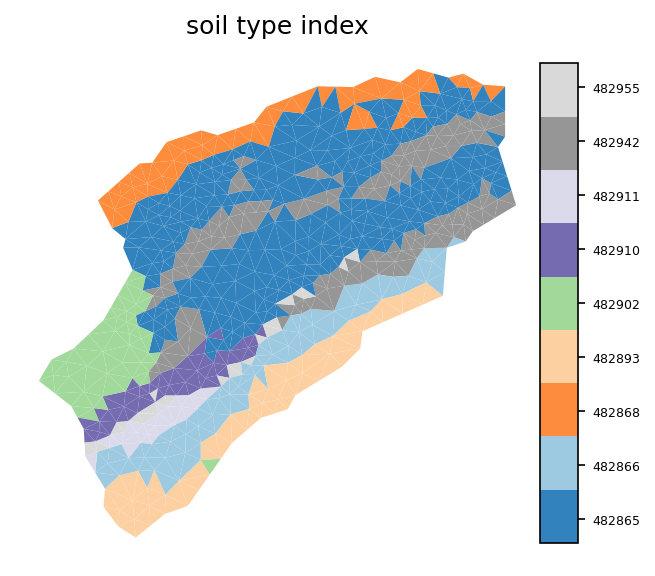

In [147]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = \
        watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.7,0.05,0.05,0.8])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm=norm
                       )

cbar = watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), 
                                                cmap=cmap, labels=labels, cax=cax)
cbar.ax.tick_params(labelsize=6)

ax.set_title('soil type index')
ax.axis('off')

In [148]:
# Note this is not just the soil ID, but also soil properties.  
# print(soil_survey_props.keys())
soil_survey_props.set_index('mukey', inplace=True)
# only select soils within the watershed
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]
soil_survey_props

residual saturation [-]  Rosetta porosity [-]  \
mukey                                                   
482865                 0.212048              0.443058   
482866                 0.165688              0.387793   
482868                 0.187116              0.448978   
482893                 0.238677              0.461007   
482902                 0.232477              0.439950   
482910                 0.240770              0.482161   
482911                      NaN                   NaN   
482942                 0.212624              0.439846   
482955                 0.247315              0.413180   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
mukey                                                      
482865                     0.000063             1.421366   
482866                     0.000242             1.879770   
482868                     0.000043             1.506506   
482893                     0.000077             1.352647   
482902                     0.000075             1.372253   
482910                     0.000068             1.353531   
482911                          NaN                  NaN   
482942                     0.000110             1.381619   
482955                     0.000076             1.352726   

        Rosetta permeability [m^2]  thickness [cm]  permeability [m^2]  \
mukey                                                                    
482865                2.991665e-13      117.388889        5.091161e-13   
482866                1.961351e-12       61.000000        9.888746e-13   
482868                5.212509e-13      136.333333        5.655162e-13   
482893                2.242123e-13      152.000000        2.012870e-13   
482902                2.012135e-13       71.000000        1.673866e-13   
482910                2.528120e-13      150.500000        1.527074e-13   
482911                         NaN      195.894737        1.939065e-13   
482942                3.691756e-13      152.000000        6.297480e-13   
482955                1.147920e-13      146.950000        1.021865e-13   

        porosity [-]  bulk density [g/cm^3]  total sand pct [%]  \
mukey                                                             
482865      0.186948               1.263238           35.931469   
482866      0.130000               1.500000           85.700000   
482868      0.143889               1.191111           28.222222   
482893      0.284561               1.294587           32.793933   
482902      0.150000               1.330000           36.356522   
482910      0.202014               1.250000           24.043513   
482911      0.221203               1.250000           28.618491   
482942      0.171842               1.321711           53.898026   
482955      0.281813               1.440000           34.844375   

        total silt pct [%]  total clay pct [%] source  
mukey                                                  
482865           40.653874           23.414656   NRCS  
482866            4.300000           10.000000   NRCS  
482868           54.472222           17.305556   NRCS  
482893           32.784649           34.421418   NRCS  
482902           34.491304           29.152174   NRCS  
482910           37.400409           38.556077   NRCS  
482911           31.674877           41.373731   NRCS  
482942           22.273026           23.828947   NRCS  
482955           35.330625           29.825000   NRCS

min, max =  0.13 0.4821610779351811


/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


(431087.0, 437753.0, 4513282.5, 4519827.5)

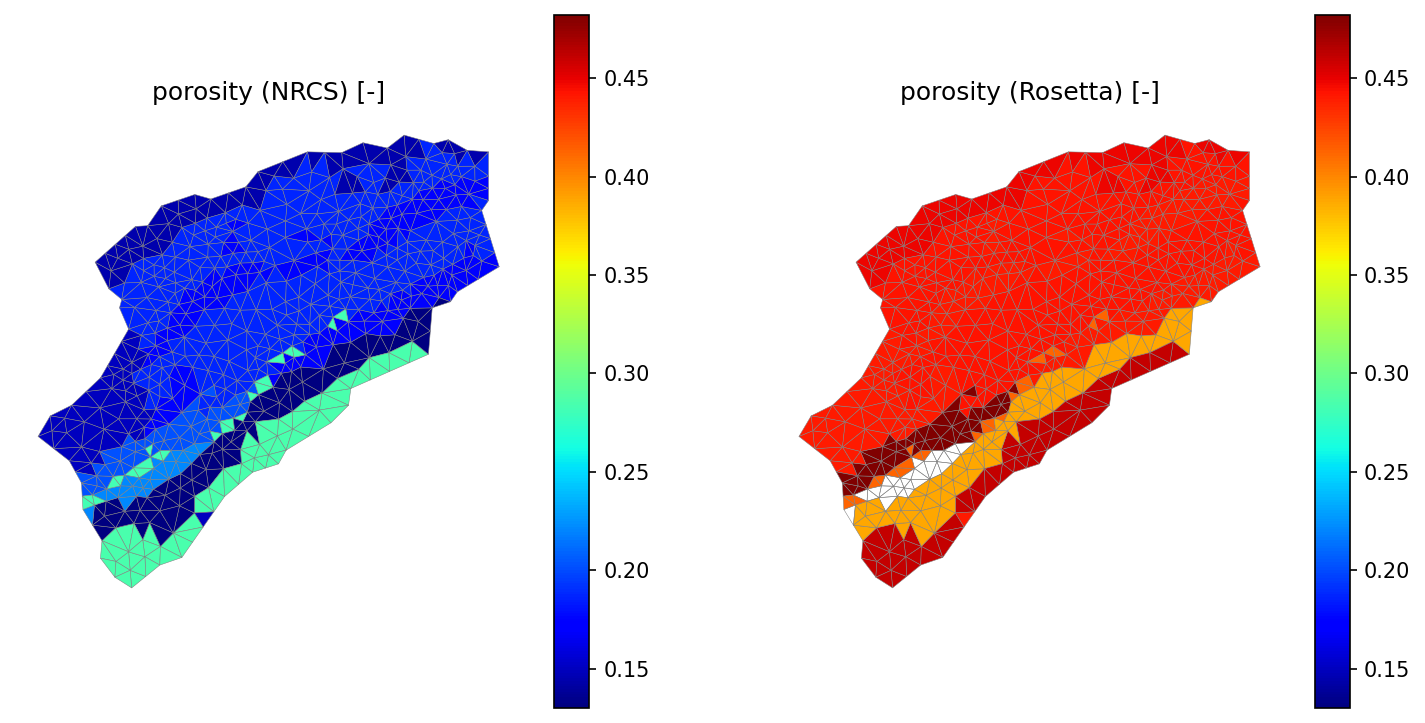

In [149]:
# To demonstrate what we mean by this, plot the porosity of the soil column.
porosity_nrcs = np.empty(soil_color.shape, 'd')
porosity_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'porosity [-]']
    porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta porosity [-]']

pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
print('min, max = ', pmin, pmax)

fig = plt.figure(figsize=(12,6))
ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity (NRCS) [-]')
ax1.axis('off')


ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('porosity (Rosetta) [-]')
ax2.axis('off')

min = -12.99060642756315, max = -12.004858782428627


/tmp/ipykernel_241/45597466.py:11: RuntimeWarning: All-NaN axis encountered
  pmin = min(np.nanmin(np.log10(soil_perm_nrcs)), np.nanmin(np.log10(soil_perm_rosetta).min()))
/tmp/ipykernel_241/45597466.py:12: RuntimeWarning: All-NaN axis encountered
  pmax = max(np.nanmax(np.log10(soil_perm_nrcs)), np.nanmax(np.log10(soil_perm_rosetta).max()))


Text(0.5, 1.0, 'log permeability (Rosetta) [m^2]')

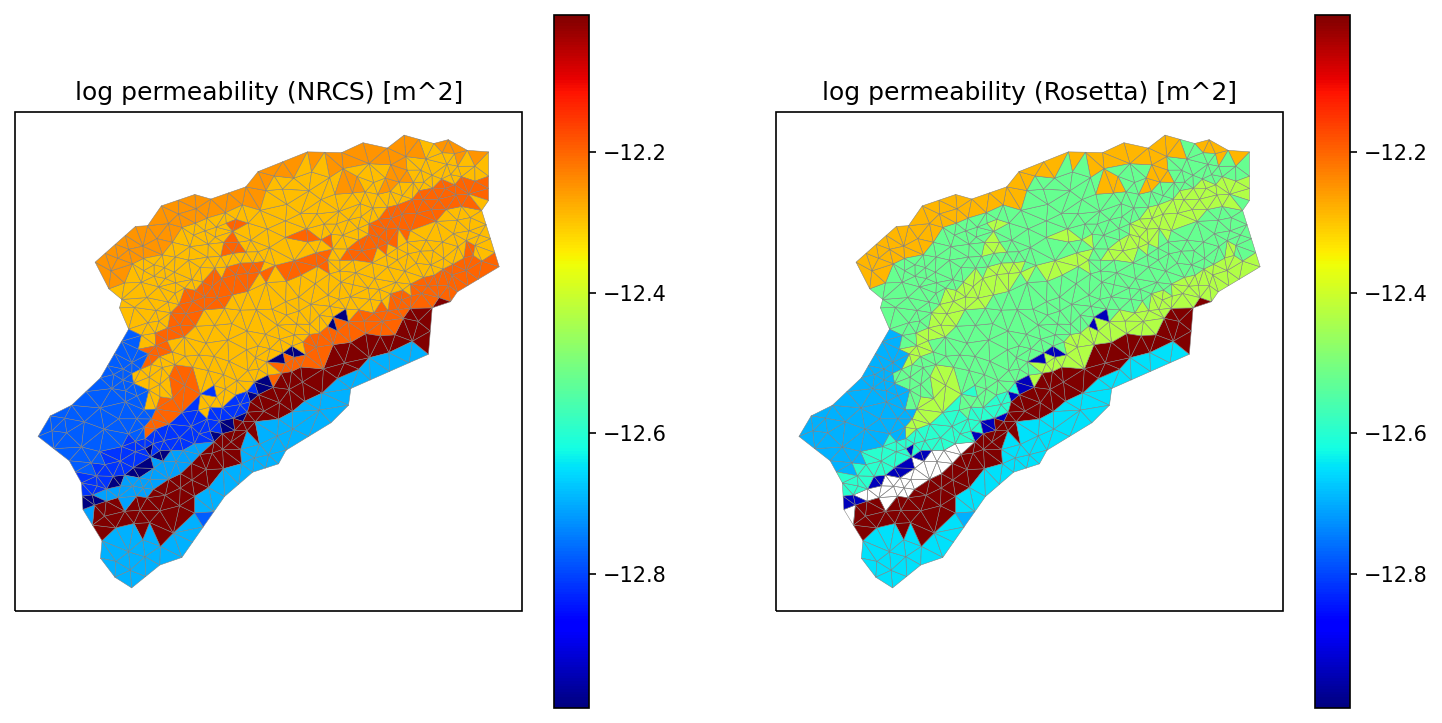

In [150]:
# averaging permeability is a tricky beast.  we average in log space, check that 
# unit conversions make sense
fig = plt.figure(figsize=(12,6))
soil_perm_nrcs = np.empty(soil_color.shape, 'd')
soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'permeability [m^2]']
    soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta permeability [m^2]']

pmin = min(np.nanmin(np.log10(soil_perm_nrcs)), np.nanmin(np.log10(soil_perm_rosetta).min()))
pmax = max(np.nanmax(np.log10(soil_perm_nrcs)), np.nanmax(np.log10(soil_perm_rosetta).max()))

  
print(f'min = {pmin}, max = {pmax}')

ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('log permeability (NRCS) [m^2]')

ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('log permeability (Rosetta) [m^2]')




Median soil thickness = 1.173888888888889 [m]


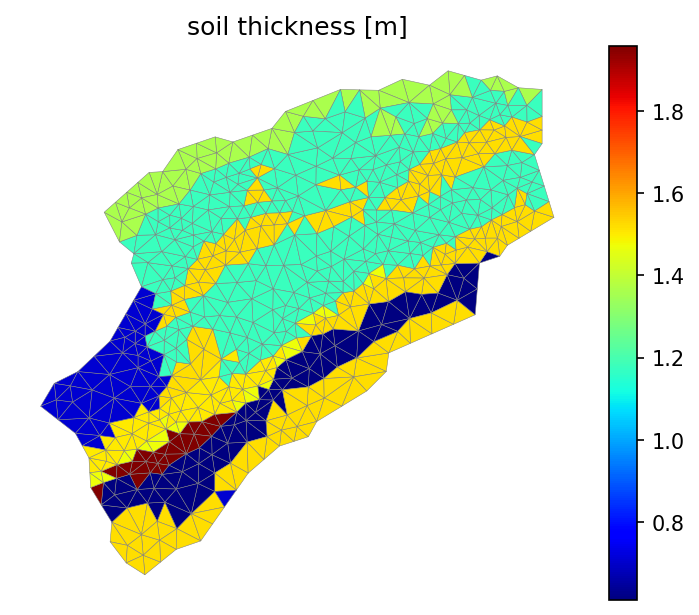

In [151]:
# finally, let's look at the soil thickness, which will define the depth of this layer
soil_thickness = np.zeros(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey, 'thickness [cm]']

# print(soil_thickness)
soil_thickness = soil_thickness / 100 # convert cm to m
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print(f'Median soil thickness = {np.nanmedian(soil_thickness)} [m]')

In [152]:
def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows, use all cols as duplicate target
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

In [153]:
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

In [154]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
# soil_survey_props_clean = soil_survey_props.copy()
soil_survey_props_clean = soil_survey_props.reset_index()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
# soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)

soil_survey_props_clean

native_index  residual saturation [-]  van Genuchten alpha [Pa^-1]  \
0        482865                 0.212048                     0.000063   
1        482866                 0.165688                     0.000242   
2        482868                 0.187116                     0.000043   
3        482893                 0.238677                     0.000077   
4        482902                 0.232477                     0.000075   
5        482910                 0.240770                     0.000068   
6        482911                      NaN                          NaN   
7        482942                 0.212624                     0.000110   
8        482955                 0.247315                     0.000076   

   van Genuchten n [-]  thickness [m]  permeability [m^2]  porosity [-] source  
0             1.421366       1.173889        5.091161e-13      0.186948   NRCS  
1             1.879770       0.610000        9.888746e-13      0.130000   NRCS  
2             1.506506       1.363333        5.655162e-13      0.143889   NRCS  
3             1.352647       1.520000        2.012870e-13      0.284561   NRCS  
4             1.372253       0.710000        1.673866e-13      0.150000   NRCS  
5             1.353531       1.505000        1.527074e-13      0.202014   NRCS  
6                  NaN       1.958947        1.939065e-13      0.221203   NRCS  
7             1.381619       1.520000        6.297480e-13      0.171842   NRCS  
8             1.352726       1.469500        1.021865e-13      0.281813   NRCS

In [155]:
# drop nans
# soil id with missing properties will be removed, and the space will be filled by geology from below (see mesh extrusion)!
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)

# remove duplicates
reindex_remove_duplicates(soil_survey_props_clean, 'native_index')

# assert soil_survey_props_clean['porosity [-]'][:].min() >= min_porosity
# assert soil_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
soil_survey_props_clean

/tmp/ipykernel_241/2530005601.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))


native_index  residual saturation [-]  van Genuchten alpha [Pa^-1]  \
0    (482866,)                 0.212048                     0.000063   
1    (482868,)                 0.165688                     0.000242   
2    (482865,)                 0.187116                     0.000043   
3    (482942,)                 0.238677                     0.000077   
4    (482902,)                 0.232477                     0.000075   
5    (482893,)                 0.240770                     0.000068   
6    (482910,)                 0.212624                     0.000110   
7    (482955,)                 0.247315                     0.000076   

   van Genuchten n [-]  thickness [m]  permeability [m^2]  porosity [-] source  
0             1.421366       1.173889        5.091161e-13      0.186948   NRCS  
1             1.879770       0.610000        9.888746e-13      0.130000   NRCS  
2             1.506506       1.363333        5.655162e-13      0.143889   NRCS  
3             1.352647       1.520000        2.012870e-13      0.284561   NRCS  
4             1.372253       0.710000        1.673866e-13      0.150000   NRCS  
5             1.353531       1.505000        1.527074e-13      0.202014   NRCS  
6             1.381619       1.520000        6.297480e-13      0.171842   NRCS  
7             1.352726       1.469500        1.021865e-13      0.281813   NRCS

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbb69851630>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7fbb69853a60>}
setting face color =  [1000 1003 1003 ... 1004 1002 1001]


(431087.0, 437753.0, 4513282.5, 4519827.5)

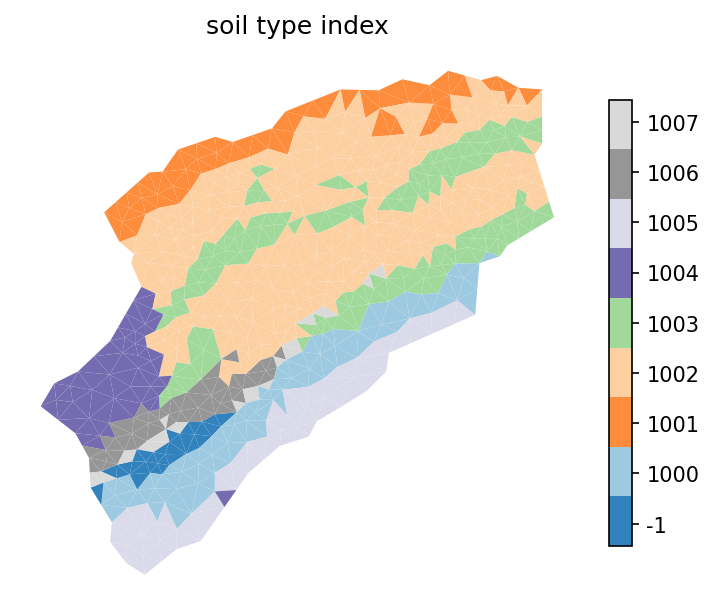

In [156]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukeys in enumerate(soil_survey_props_clean['native_index']):
    for mukey in mukeys:
        soil_color_new[np.where(soil_color == mukey)] = 1000+new_id

# # make sure no -1 in soil ids
# assert -1 not in np.unique(soil_color_new)
        
# image the new soil_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

### GLHYMPS geologic layer

A copy of GLHYMPS v2 geologic shapefile has to be manually downloaded before running the following scripts (see source section for download instructions).

This will get properties (i.e., permeability and porosity) for each geologic layer. In case of missing data, default values of permeability (inf?) and porosity (0.01) will be used. Default van Genuchten alpha, n, and residual saturation are used due to lack of soil/silt/clay pct information. <span style="color:blue;"> </span>

In [209]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = \
    watershed_workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                  crs, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


2025-04-24 17:36:46,086 - root - INFO: target bounds: (431389.99999981525, 4513580.00000015, 437449.99999981484, 4519530.000000152)
2025-04-24 17:36:46,087 - root - INFO: 
2025-04-24 17:36:46,088 - root - INFO: Loading shapes
2025-04-24 17:36:46,089 - root - INFO: ------------------------------
2025-04-24 17:36:46,090 - root - INFO: Getting shapes of GLHYMPS on bounds: (431389.99999981525, 4513580.00000015, 437449.99999981484, 4519530.000000152)
2025-04-24 17:36:46,273 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
2025-04-24 17:45:42,735 - root - INFO: ... found 27 shapes
2025-04-24 17:45:42,736 - root - INFO: Converting to shapely
2025-04-24 17:45:42,740 - root - INFO:  ... done
2025-04-24 17:45:42,743 - root - INFO: Converting to requested CRS
2025-04-24 17:45:42,804 - root - INFO:  ... done
2025-04-24 17:45:42,808 - root - INFO: shape union bounds: (427185.9237627287, 4507553.019948782, 446573.2343866725, 4528005.447103774)
2025-04-24 17:45:42,809 - root - INFO: Coloring sh

In [210]:
geo_color = geo_color.astype(int)
geo_survey_props.set_index('id', inplace=True)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]
geo_survey_props

source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
id                                                                   
762290   GLHYMPS        1.584893e-12             1.5          0.06   
762306   GLHYMPS        3.162278e-13             0.9          0.27   
762336   GLHYMPS        1.584893e-12             1.5          0.06   
762351   GLHYMPS        3.162278e-17             1.7          0.12   
762357   GLHYMPS        3.162278e-17             1.7          0.12   
762390   GLHYMPS        1.584893e-12             1.5          0.06   
762391   GLHYMPS        3.162278e-13             0.9          0.27   
762396   GLHYMPS        1.584893e-12             1.5          0.06   
762400   GLHYMPS        3.162278e-17             1.7          0.12   
762405   GLHYMPS        3.162278e-17             1.7          0.12   
762415   GLHYMPS        3.162278e-13             0.9          0.27   
762421   GLHYMPS        3.162278e-17             1.7          0.12   
762435   GLHYMPS        3.162278e-13             0.9          0.27   
762445   GLHYMPS        3.162278e-17             1.7          0.12   
762451   GLHYMPS        3.162278e-17             1.7          0.12   
762462   GLHYMPS        3.162278e-13             0.9          0.27   
1791767  GLHYMPS        1.584893e-12             1.5          0.06   
1791796  GLHYMPS        1.584893e-12             1.5          0.06   

         van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
id                                                          
762290                      0.002240                  2.0   
762306                      0.000472                  2.0   
762336                      0.002240                  2.0   
762351                      0.000007                  2.0   
762357                      0.000007                  2.0   
762390                      0.002240                  2.0   
762391                      0.000472                  2.0   
762396                      0.002240                  2.0   
762400                      0.000007                  2.0   
762405                      0.000007                  2.0   
762415                      0.000472                  2.0   
762421                      0.000007                  2.0   
762435                      0.000472                  2.0   
762445                      0.000007                  2.0   
762451                      0.000007                  2.0   
762462                      0.000472                  2.0   
1791767                     0.002240                  2.0   
1791796                     0.002240                  2.0   

         residual saturation [-]  
id                                
762290                      0.01  
762306                      0.01  
762336                      0.01  
762351                      0.01  
762357                      0.01  
762390                      0.01  
762391                      0.01  
762396                      0.01  
762400                      0.01  
762405                      0.01  
762415                      0.01  
762421                      0.01  
762435                      0.01  
762445                      0.01  
762451                      0.01  
762462                      0.01  
1791767                     0.01  
1791796                     0.01

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbb6b6d8fa0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7fbb6b6d9300>}
setting face color =  [762462 762336 762351 ... 762445 762306 762306]


(431087.0, 437753.0, 4513282.5, 4519827.5)

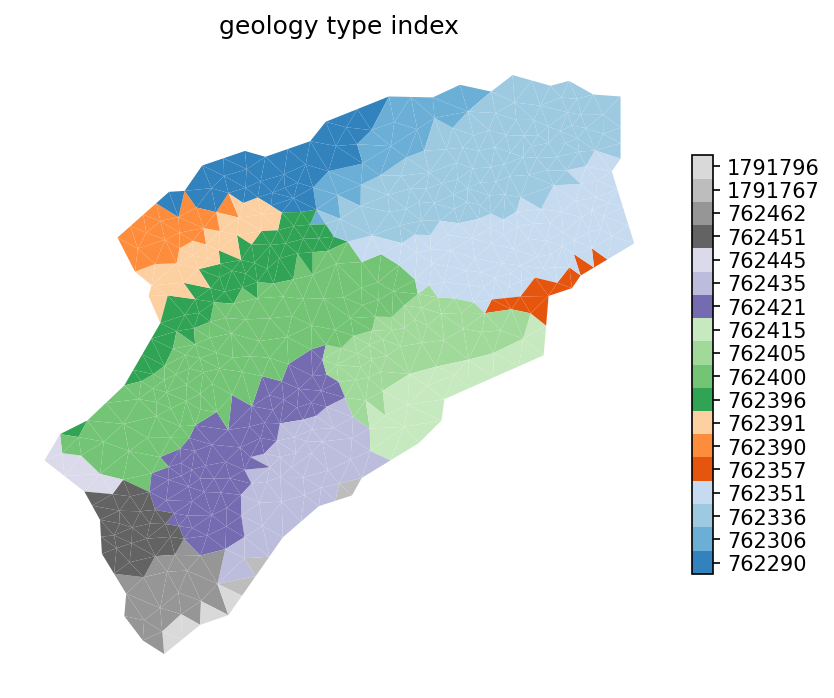

In [211]:
# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color, cmap = 'tab20c')


mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels = labels) 

ax.set_title('geology type index')
ax.axis('off')

min = -16.5, max = -11.8


(431087.0, 437753.0, 4513282.5, 4519827.5)

<Figure size 1800x900 with 0 Axes>

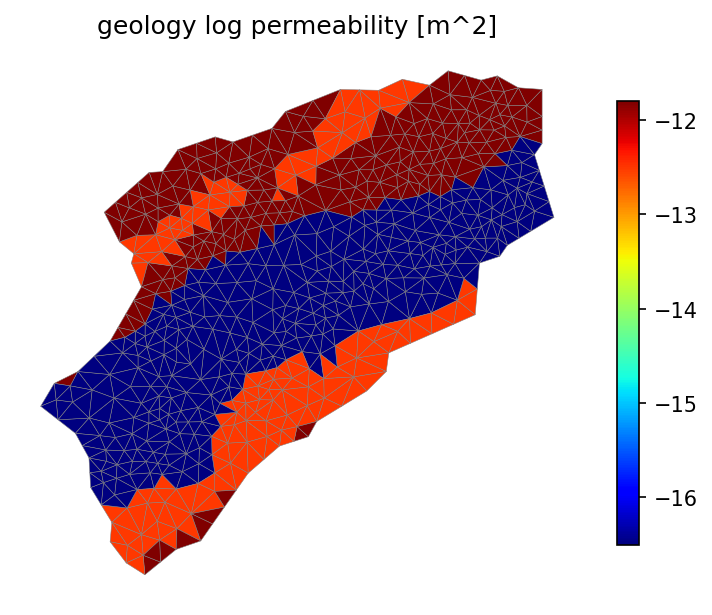

In [212]:
# averaging permeability is a tricky beast.  we average in log space, check that unit conversions make sense
fig = plt.figure(figsize=(12,6))
geol_perm = np.empty(geo_color.shape, 'd')
# soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for i in geo_survey_props.index:
    geol_perm[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
#     soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey, 'Rosetta permeability [m^2]']

pmin = min(np.nanmin(np.log10(geol_perm)), np.nanmin(np.log10(geol_perm)))
pmax = max(np.nanmax(np.log10(geol_perm)), np.nanmax(np.log10(geol_perm)))

  
print(f'min = {pmin}, max = {pmax}')
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(geol_perm), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp, shrink=0.8)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')

In [213]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props = geo_survey_props.reset_index()
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)

# remove duplicates
reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
# assert geo_survey_props_clean['porosity [-]'][:].min() >= min_porosity
# assert geo_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
# assert geo_survey_props_clean['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

geo_survey_props_clean

/tmp/ipykernel_241/2530005601.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))


native_index   source  \
0  (762351, 762357, 762400, 762405, 762421, 76244...  GLHYMPS   
1           (762306, 762391, 762415, 762435, 762462)  GLHYMPS   
2  (762290, 762336, 762390, 762396, 1791767, 1791...  GLHYMPS   

   permeability [m^2]  porosity [-]  van Genuchten alpha [Pa^-1]  \
0        1.584893e-12          0.06                     0.002240   
1        3.162278e-13          0.27                     0.000472   
2        3.162278e-17          0.12                     0.000007   

   van Genuchten n [-]  residual saturation [-]  
0                  2.0                     0.01  
1                  2.0                     0.01  
2                  2.0                     0.01

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbb6b9772e0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7fbb6b977fa0>}
setting face color =  [101 102 100 ... 100 101 101]


(431087.0, 437753.0, 4513282.5, 4519827.5)

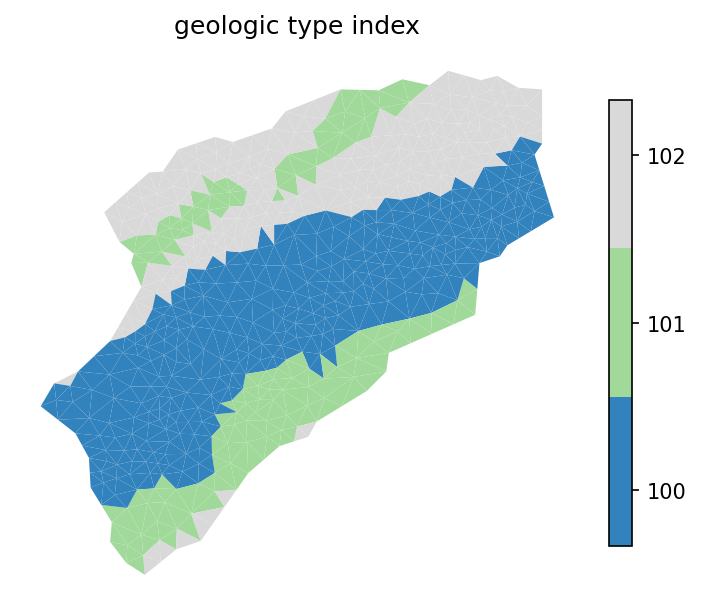

In [214]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+ new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [215]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], 
                                                                 watershed.exterior(), crs, 
                                                                 nodata=-99999)
                                        #, variable='BDTICM') # note, this argument needed for 
                                        # using the default SoilGrids dataset.

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2025-04-24 17:45:43,940 - root - INFO: 
2025-04-24 17:45:43,941 - root - INFO: Loading Raster
2025-04-24 17:45:43,942 - root - INFO: ------------------------------
2025-04-24 17:45:43,944 - root - INFO: Collecting raster
2025-04-24 17:45:43,970 - root - INFO: bounds in my_crs: (-111.81319870916158, 40.770432630919686, -111.74160221213211, 40.8243145359636)
2025-04-24 17:45:43,990 - root - INFO: ... got raster of shape: (27, 36)
2025-04-24 17:45:43,992 - root - INFO: ... got raster bounds: (-111.814594243, 40.826257447, -111.739594255, 40.770007456)


(431087.0, 437753.0, 4513282.5, 4519827.5)

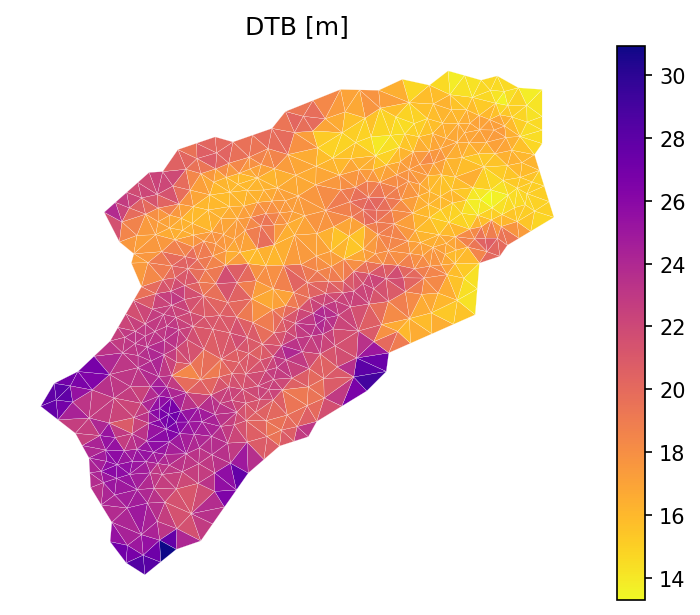

In [216]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp)
title = ax.set_title('DTB [m]')
ax.axis('off')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs
* 1000-9999 : soil layer material IDs




In [217]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

In [218]:
bedrock_props = watershed_workflow.soil_properties.get_bedrock_properties()
bedrock_props['source'] = 'SoilGrids'
bedrock_props['native_index'] = '(999,)'

In [219]:
# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])
subsurface_props

native_index     source  \
ats_id                                                                 
100     (762351, 762357, 762400, 762405, 762421, 76244...    GLHYMPS   
101              (762306, 762391, 762415, 762435, 762462)    GLHYMPS   
102     (762290, 762336, 762390, 762396, 1791767, 1791...    GLHYMPS   
1000                                            (482866,)       NRCS   
1001                                            (482868,)       NRCS   
1002                                            (482865,)       NRCS   
1003                                            (482942,)       NRCS   
1004                                            (482902,)       NRCS   
1005                                            (482893,)       NRCS   
1006                                            (482910,)       NRCS   
1007                                            (482955,)       NRCS   
999                                                (999,)  SoilGrids   

        permeability [m^2]  porosity [-]  van Genuchten alpha [Pa^-1]  \
ats_id                                                                  
100           1.584893e-12      0.060000                     0.002240   
101           3.162278e-13      0.270000                     0.000472   
102           3.162278e-17      0.120000                     0.000007   
1000          5.091161e-13      0.186948                     0.000063   
1001          9.888746e-13      0.130000                     0.000242   
1002          5.655162e-13      0.143889                     0.000043   
1003          2.012870e-13      0.284561                     0.000077   
1004          1.673866e-13      0.150000                     0.000075   
1005          1.527074e-13      0.202014                     0.000068   
1006          6.297480e-13      0.171842                     0.000110   
1007          1.021865e-13      0.281813                     0.000076   
999           1.000000e-16      0.050000                     0.000019   

        van Genuchten n [-]  residual saturation [-]  thickness [m]  
ats_id                                                               
100                2.000000                 0.010000            NaN  
101                2.000000                 0.010000            NaN  
102                2.000000                 0.010000            NaN  
1000               1.421366                 0.212048       1.173889  
1001               1.879770                 0.165688       0.610000  
1002               1.506506                 0.187116       1.363333  
1003               1.352647                 0.238677       1.520000  
1004               1.372253                 0.232477       0.710000  
1005               1.353531                 0.240770       1.505000  
1006               1.381619                 0.212624       1.520000  
1007               1.352726                 0.247315       1.469500  
999                3.000000                 0.010000            NaN

In [220]:
# save the properties to disk for use in generating input file
config['subsurface_properties_filename'] = os.path.join('..', '..', 'data', 'examples',watershed_name, 'processed', 'watershed_subsurface_properties.csv')
subsurface_props.to_csv(config['subsurface_properties_filename'])

Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [221]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user, but we are hard-coding this for this watershed_workflow.
total_thickness = np.ceil(DTB.max())
logging.info(f'max DTB: {total_thickness} m')

2025-04-24 17:45:44,364 - root - INFO: max DTB: 31.0 m


In [222]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)

[0.05597246 0.07021336 0.09755479 0.14871062 0.24526776 0.38545006
 0.49683094 0.5       ]


In [223]:
# this looks like it would work out:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]

In [224]:
# a 2 m soil thickness and a maximum of 27 m depth to bedrock suggests a
# geologic layer of 13 * 2 m cells or something finer
dzs_geo = [2.0]*2 + [4.0]*7


In [225]:
assert np.sum(dzs_soil) + np.sum(dzs_geo) > total_thickness, "The sum of soil and geology layers should be greater than the total thickness!"

In [226]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    br_or_geo = np.where(depth < DTB, geo_color_new, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(np.where(depth < DTB, geo_color_new, 999))
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2025-04-24 17:45:44,582 - root - INFO: Cell summary:
2025-04-24 17:45:44,583 - root - INFO: ------------------------------------------------------------
2025-04-24 17:45:44,583 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2025-04-24 17:45:44,584 - root - INFO: ------------------------------------------------------------
2025-04-24 17:45:44,584 - root - INFO:  00 	| 00 	| 1000 	|   0.050000 	|   0.000000
2025-04-24 17:45:44,586 - root - INFO:  01 	| 01 	| 1000 	|   0.050000 	|   0.050000
2025-04-24 17:45:44,586 - root - INFO:  02 	| 02 	| 1000 	|   0.050000 	|   0.100000
2025-04-24 17:45:44,586 - root - INFO:  03 	| 03 	| 1000 	|   0.120000 	|   0.150000
2025-04-24 17:45:44,587 - root - INFO:  04 	| 04 	| 1000 	|   0.230000 	|   0.270000
2025-04-24 17:45:44,587 - root - INFO:  05 	| 05 	|  101 	|   0.500000 	|   0.500000
2025-04-24 17:45:44,588 - root - INFO:  06 	| 06 	|  101 	|   0.500000 	|   1.000000
2025-04-24 17:45:44,588 - root - INFO:  07 	| 07 	|  101 	|   0.500000 	|   1.5

In [227]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [228]:
# # add back on land cover side sets
# surf_ss = m3.side_sets[1]

# for index, name in zip(nlcd_indices, nlcd_labels):
#     where = np.where(lc == index)[0]
#     ss = watershed_workflow.mesh.SideSet(name, int(index), 
#                             [surf_ss.cell_list[w] for w in where],
#                             [surf_ss.side_list[w] for w in where])        
#     m3.side_sets.append(ss)

In [229]:
print(f'total number of cells: {m3.num_cells}')
print('---------------')
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
ls = {}
for i in m3.labeled_sets:
    ls[i.name] = {'setid':i.setid, 'entity':i.entity}
    print(f'{i.setid} : {i.entity} : {len(i.ent_ids)} : "{i.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
ss = {}
for i in m3.side_sets:
    ss[i.name] = {'setid':i.setid}
    print(f'{i.setid} : FACE : {len(i.cell_list)} : "{i.name}"')

total number of cells: 17374
---------------
2D labeled sets
---------------
10000 : CELL : 1022 : "RedButteCreek"
10001 : CELL : 1022 : "RedButteCreek surface"
10002 : FACE : 82 : "RedButteCreek boundary"
10003 : FACE : 5 : "RedButteCreek outlet"
10004 : FACE : 5 : "surface domain outlet"
9 : CELL : 867 : "Savannas"
10 : CELL : 155 : "Grasslands"

Extruded 3D labeled sets
------------------------
10000 : CELL : 17374 : "RedButteCreek"

Extruded 3D side sets
---------------------
1 : FACE : 1022 : "bottom"
2 : FACE : 1022 : "surface"
3 : FACE : 1394 : "external_sides"
10001 : FACE : 1022 : "RedButteCreek surface"
10002 : FACE : 1394 : "RedButteCreek boundary"
10003 : FACE : 85 : "RedButteCreek outlet"
10004 : FACE : 85 : "surface domain outlet"
9 : FACE : 867 : "Savannas"
10 : FACE : 155 : "Grasslands"


In [230]:
config['labeled_sets'] = ls
config['side_sets'] = ss

### Save mesh file

This will write the 3D mesh to ExodusII using arbitrary polyhedra specification. 

In [231]:
config['mesh_filename'] = os.path.join('..', '..', 'data', 'examples',watershed_name, 'processed','watershed_mesh.exo')

try:
    os.remove(config['mesh_filename'])
except FileNotFoundError:
    pass
m3.write_exodus(config['mesh_filename'])

Opening exodus file: ../../data/examples/RedButteCreek/processed/watershed_mesh.exo


2025-04-24 17:45:45,740 - root - INFO: adding side set: 1
2025-04-24 17:45:45,800 - root - INFO: adding side set: 2
2025-04-24 17:45:45,856 - root - INFO: adding side set: 3
2025-04-24 17:45:45,937 - root - INFO: adding side set: 10001
2025-04-24 17:45:46,004 - root - INFO: adding side set: 10002
2025-04-24 17:45:46,062 - root - INFO: adding side set: 10003
2025-04-24 17:45:46,119 - root - INFO: adding side set: 10004
2025-04-24 17:45:46,181 - root - INFO: adding side set: 9
2025-04-24 17:45:46,240 - root - INFO: adding side set: 10
2025-04-24 17:45:46,297 - root - INFO: adding elem set: 10000


Closing exodus file: ../../data/examples/RedButteCreek/processed/watershed_mesh.exo


In [232]:
config['start_date'] = start_date
config['end_date'] = end_date
config['origin_date'] = origin_date
config['nyears_cyclic_steadystate'] = nyears_cyclic_steadystate 

In [233]:
config

{'catchment_labels': ['RedButteCreek'],
 'nlcd_indices': [9, 10],
 'nlcd_labels': ['Savannas', 'Grasslands'],
 'LAI_filename': '../../data/examples/RedButteCreek/processed/watershed_lai_raw.h5',
 'LAI_typical_filename': '../../data/examples/RedButteCreek/processed/watershed_lai_typical.h5',
 'subsurface_properties_filename': '../../data/examples/RedButteCreek/processed/watershed_subsurface_properties.csv',
 'labeled_sets': {'RedButteCreek': {'setid': 10000, 'entity': 'CELL'}},
 'side_sets': {'bottom': {'setid': 1},
  'surface': {'setid': 2},
  'external_sides': {'setid': 3},
  'RedButteCreek surface': {'setid': 10001},
  'RedButteCreek boundary': {'setid': 10002},
  'RedButteCreek outlet': {'setid': 10003},
  'surface domain outlet': {'setid': 10004},
  'Savannas': {'setid': 9},
  'Grasslands': {'setid': 10}},
 'mesh_filename': '../../data/examples/RedButteCreek/processed/watershed_mesh.exo',
 'start_date': '2010-10-1',
 'end_date': '2020-10-01',
 'origin_date': '1980-1-1',
 'nyears_cy

In [234]:
# Save dictionary to a file
config['config_file'] = os.path.join('..', '..', 'data', 'examples',watershed_name, 'processed','config.yaml')

with open(config_fname, 'w') as file:
    yaml.dump(config, file)